In [1]:
import os
import glob as glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import hiddenlayer as hl
from tqdm import tqdm



In [2]:
# !pip3 install hiddenlayer

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid


In [4]:
print(os.getcwd())
os.chdir('..')
os.getcwd()


/home/anhnguyen/Documents/GAN/src


'/home/anhnguyen/Documents/GAN'

In [5]:
DATA_DIR = glob.glob(f'animeFaces64')[0]
DATA_DIR

'animeFaces64'

In [6]:
n_epochs = 25
crit_repeats = 5
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
z_dim = 128


In [7]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
batch_size = 64
image_size = 64
#Training
#Using data data loader, turn every images to Torch Tensor, then normalize by stats
train_ds = ImageFolder(DATA_DIR, transform=transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
    ]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)

In [8]:
#Other preproc and postproc functions:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    # ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

def show_tensor_images(image_tensor, num_images=25, size=(3, 64, 64)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
#Moving the dataloader to GPU
train_dl = DeviceDataLoader(train_dl, device)

In [12]:
class Critic(nn.Module):
    '''
    Discriminator Class
    Values:
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim*2),
            self.make_disc_block(hidden_dim*2, hidden_dim * 4),
            self.make_disc_block(hidden_dim*4, hidden_dim * 8),
            self.make_disc_block(hidden_dim * 8, 1,stride = 1, padding = 0,final_layer=True),
#             self.make_disc_block(hidden_dim, 1, final_layer=True),

        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding = 1,  final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding = padding, bias = False),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride, padding = padding, bias = False),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

<ipython-input-12-4c75ef5db7b8>:52: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return disc_pred.view(len(disc_pred), -1)
/home/anhnguyen/.local/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:435: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


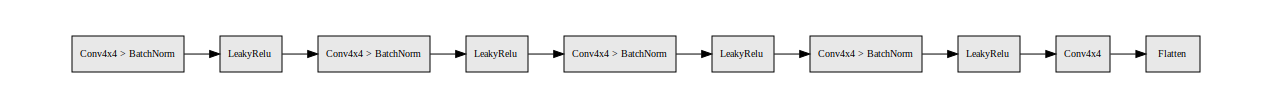

In [13]:
#Test and visualize
# Saving Model
critic = Critic(im_chan = 3)
temp = torch.rand((1,3,64,64))#.cuda()
critic.eval()

traced_script_module = torch.jit.trace(critic, temp)

traced_script_module.save("critic64.pt")    

hl.build_graph(critic, temp)

In [14]:
#Moving discriminator to device
critic.to(device)

Critic(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, tr

In [15]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8, stride = 1, padding = 0),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding = 1, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding = padding, bias = False),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=stride, padding = padding, bias = False),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [16]:
latent_size = 128

<ipython-input-15-64d3f993eddf>:54: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return noise.view(len(noise), self.z_dim, 1, 1)
/home/anhnguyen/.local/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:435: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to inference mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


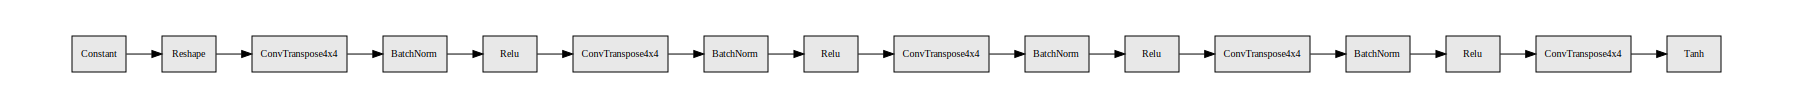

In [17]:
#Test and visualize
# Saving Model
generator = Generator(z_dim = latent_size, im_chan = 3)
temp = torch.rand((1,latent_size,1,1))
generator.eval()

traced_script_module = torch.jit.trace(generator, temp)

traced_script_module.save("generator64.pt")    

hl.build_graph(generator, temp)

torch.Size([64, 3, 64, 64])


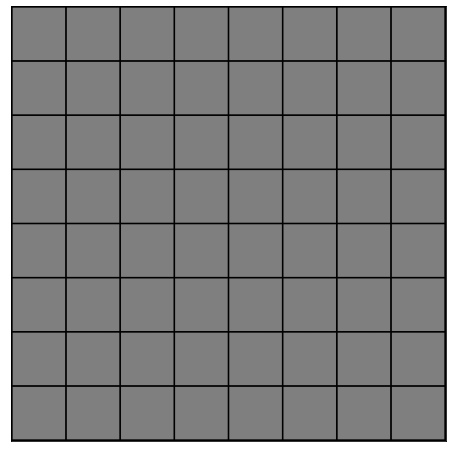

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
#Moving generator to device
generator = to_device(generator, device)


In [20]:
# Init weights, this is for MNISt dataset
# def weights_init(m):
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
#     if isinstance(m, nn.BatchNorm2d):
#         torch.nn.init.normal_(m.weight, 0.0, 0.02)
#         torch.nn.init.constant_(m.bias, 0)
# generator = generator.apply(weights_init)
# critic = critic.apply(weights_init)

In [21]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [22]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)

    
    # Penalize the mean squared distance of the gradient norms from 1
    #### START CODE HERE ####
    penalty = torch.mean((gradient_norm - 1)**2)
#     print(penalty)
    #### END CODE HERE ####
    return penalty

In [23]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    #### START CODE HERE ####
    gen_loss = -torch.mean(crit_fake_pred)
    #### END CODE HERE ####
    return gen_loss

In [24]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    #### START CODE HERE ####
    crit_loss =  torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    #### END CODE HERE ####
    return crit_loss

In [25]:
from torchvision.utils import save_image
sample_dir = 'generated_64'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


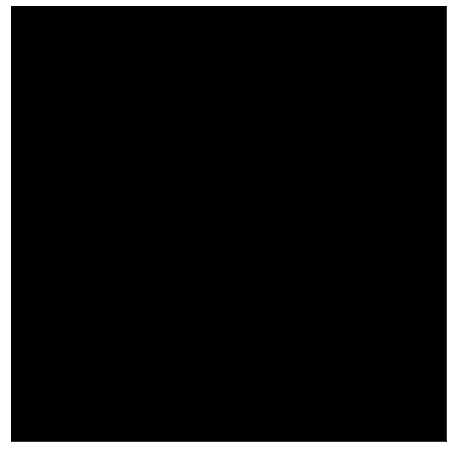

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)


In [27]:
gen_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta_1, beta_2))
crit_opt = torch.optim.Adam(critic.parameters(), lr=lr, betas=(beta_1, beta_2))

In [28]:
model_folder = 'model_weights'

100%|██████████| 994/994 [10:20<00:00,  1.60it/s]


Saving generated-images-0000.png
Epoch 0: Generator loss: -14.243776006505112, critic loss: -45.18967456433852


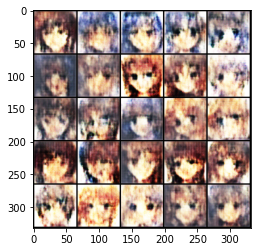

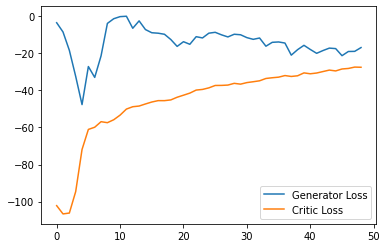

100%|██████████| 994/994 [10:25<00:00,  1.59it/s]


Saving generated-images-0001.png
Epoch 1: Generator loss: -11.32066290794124, critic loss: -21.920051742799334


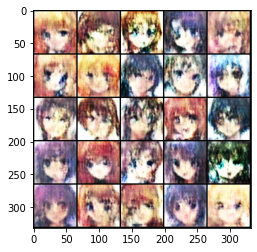

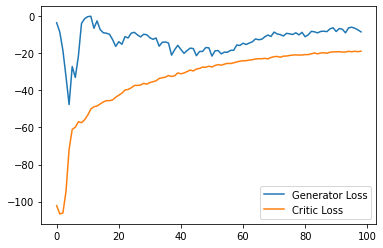

100%|██████████| 994/994 [10:25<00:00,  1.59it/s]


Saving generated-images-0002.png
Epoch 2: Generator loss: -1.4492246649065008, critic loss: -16.63150349824239


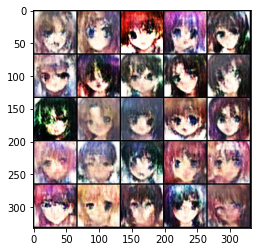

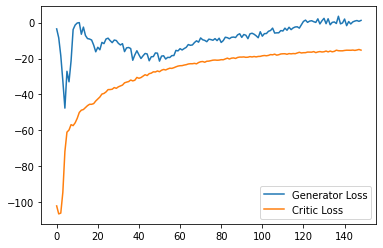

 66%|██████▌   | 654/994 [06:55<03:36,  1.57it/s]

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
display_step = len(train_dl)
torch.cuda.empty_cache()
# temp = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(train_dl):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        
        #Update the critics 5 times
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = generator(fake_noise)
            crit_fake_pred = critic(fake.detach())
            crit_real_pred = critic(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(critic, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = generator(fake_noise_2)
        crit_fake_pred = critic(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        
#         temp += 1
#         if(temp > 200):
#             save_samples(epoch, fixed_latent, show=False)


        ### Visualization code ###
    save_samples(epoch, fixed_latent, show=False)

    gen_mean = sum(generator_losses[-display_step:]) / display_step
    crit_mean = sum(critic_losses[-display_step:]) / display_step
    print(f"Epoch {epoch}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
    show_tensor_images(generator(get_noise(25, z_dim, device=device)))
    step_bins = 20
    num_examples = (len(generator_losses) // step_bins) * step_bins
    plt.plot(
            range(num_examples // step_bins), 
            torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Generator Loss"
        )
    plt.plot(
            range(num_examples // step_bins), 
            torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Critic Loss"
        )
    plt.legend()
    plt.show()
    
    # Save the model checkpoints
    
    torch.save(generator.state_dict(), f'{model_folder}/G_64_E{epoch}.pth')
    torch.save(critic.state_dict(), f'{model_folder}/C_64_E{epoch}.pth')


In [ ]:
files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()
for file in files[-10:]:
    im = plt.imread(file)
    plt.imshow(im)
    plt.show()

In [ ]:
import cv2
import os
#Saving vids

vid_fname = f'{sample_dir}/DC-WGAN-GP_AnimeFace64.avi'

img_array = []
for file in files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.show()
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MJPG'), 1, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()